# Project 7: Time Series Analysis
Time series analysis for the mean temperature data collected by Berlin weather stations (Tempelhof, Dahlem, Treptow) in the years 1876 to 2021. Data made available by www.ecad.eu. There are some missing data in the time series, but overall the data set is rather consistent and accurate. The data analysis was conducted during the Spiced Academy Data Science Bootcamp.

In [162]:
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
from dateutil import parser
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf
import scipy.stats as stats
import pylab as py

In [62]:
sns.set()
plt.rcParams['figure.figsize'] = (20, 10)

In [63]:
#Reading mean temperature data dowloaded from ECAD
df = pd.read_csv(os.path.join("data","TG_STAID002759.txt"), names = ['souid', 'date', 'tg', 'q_tg'], 
                 header=0 )

In [64]:
df.head()

,souid,date,tg,q_tg
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [65]:
df.shape

(53051, 4)

In [66]:
df['souid'].unique().tolist() #The data downloaded contains measurements also done by other stations
#About half of the data comes from station 111448 (BERLIN-TEMPELHOF) and 127488 BERLIN-DAHLEM (LFAG),
#only a small portion (364) from station 128124 (BERLIN-TREPTOW)

[127488, 128124, 111448]

In [67]:
df.groupby('souid').count()

,date,tg,q_tg
souid,,,
111448,26754,26754,26754
127488,25933,25933,25933
128124,364,364,364


In [68]:
df.groupby('q_tg').count() #There are 1 suspect and 195 missing data quality labels.

,souid,date,tg
q_tg,,,
0,52855,52855,52855
1,1,1,1
9,195,195,195


In [69]:
df.dtypes

souid    int64
date     int64
tg       int64
q_tg     int64
dtype: object

In [70]:
#Transforming the date column into a pandas datetime object
df['date'] = df['date'].astype(str)

In [71]:
df.dtypes

souid     int64
date     object
tg        int64
q_tg      int64
dtype: object

In [72]:
df['date']= pd.to_datetime(df['date'])

In [73]:
df

,souid,date,tg,q_tg
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0
...,...,...,...,...
53046,111448,2021-03-27,69,0
53047,111448,2021-03-28,77,0
53048,111448,2021-03-29,144,0
53049,111448,2021-03-30,149,0


In [74]:
#Casting the date column as df index
df = df.set_index('date')

In [75]:
df

,souid,tg,q_tg
date,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
...,...,...,...
2021-03-27,111448,69,0
2021-03-28,111448,77,0
2021-03-29,111448,144,0


In [76]:
# Checking for gaps in the time series
(df.index.to_series().diff()> pd.Timedelta(days=1)).value_counts()

False    53051
Name: date, dtype: int64

In [77]:
temp = df.index.to_series().diff() > pd.Timedelta(days=1)

In [78]:
df.index.to_series().diff().sort_values()

date
1876-01-02   1 days
1972-10-25   1 days
1972-10-26   1 days
1972-10-27   1 days
1972-10-28   1 days
              ...  
1924-06-07   1 days
1924-06-08   1 days
1924-05-29   1 days
2021-03-31   1 days
1876-01-01      NaT
Name: date, Length: 53051, dtype: timedelta64[ns]

In [79]:
#I interpolate the temperature data where they are missing (code -9999) using the avg() of the previous
#and following year
df['q_tg'].astype(int)
bad_data_index = df[df['q_tg']==9 ].index.tolist()

for index in bad_data_index:
    yb = datetime(index.year - 1, index.month, index.day)
    yf = datetime(index.year + 1, index.month, index.day)
    temp_yb = df.at[yb,'tg']
    temp_yf = df.at[yf,'tg']
    repl_val = statistics.mean([temp_yb,temp_yf])
    df.at[index, 'tg'] = repl_val

In [80]:
#Dividing the temperature column by 10 to get Celsius not 0.1 C
df['tg'] = df['tg']/10

In [81]:
#Dropping the data quality control as not helpful anymore
df.drop('q_tg', axis=1, inplace=True)

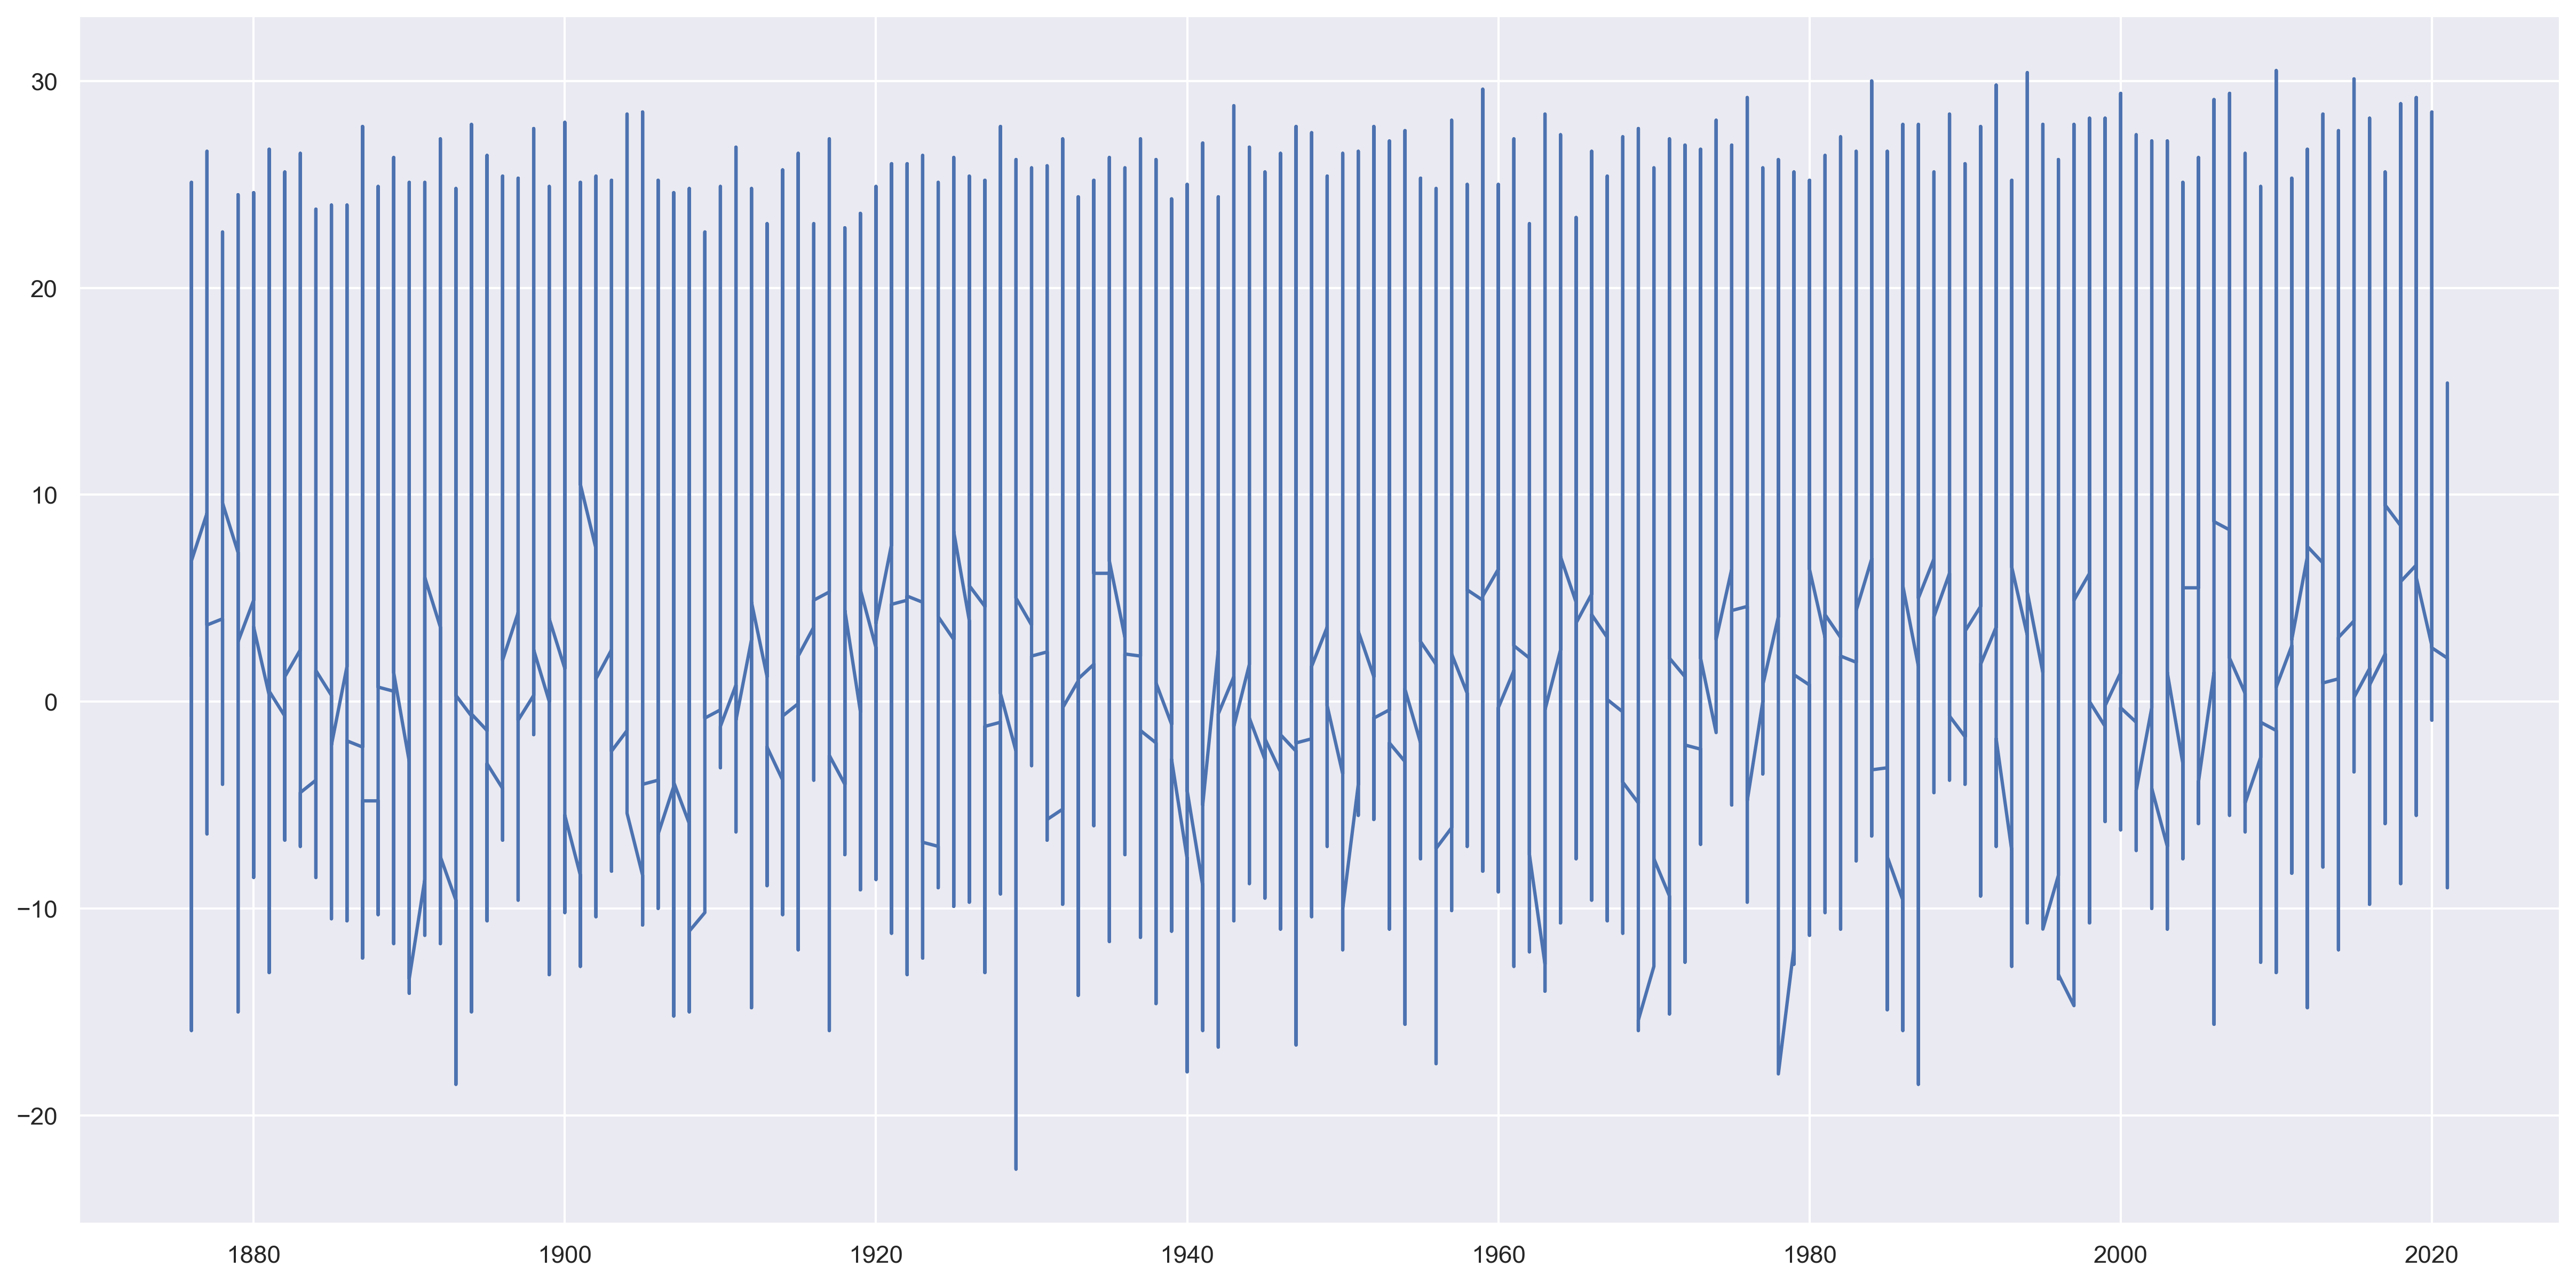

In [82]:
#df.plot(y='tg', use_index=True)

plt.figure(figsize =(20, 10), dpi = 300)
plt.plot(df.index.year, df['tg']);

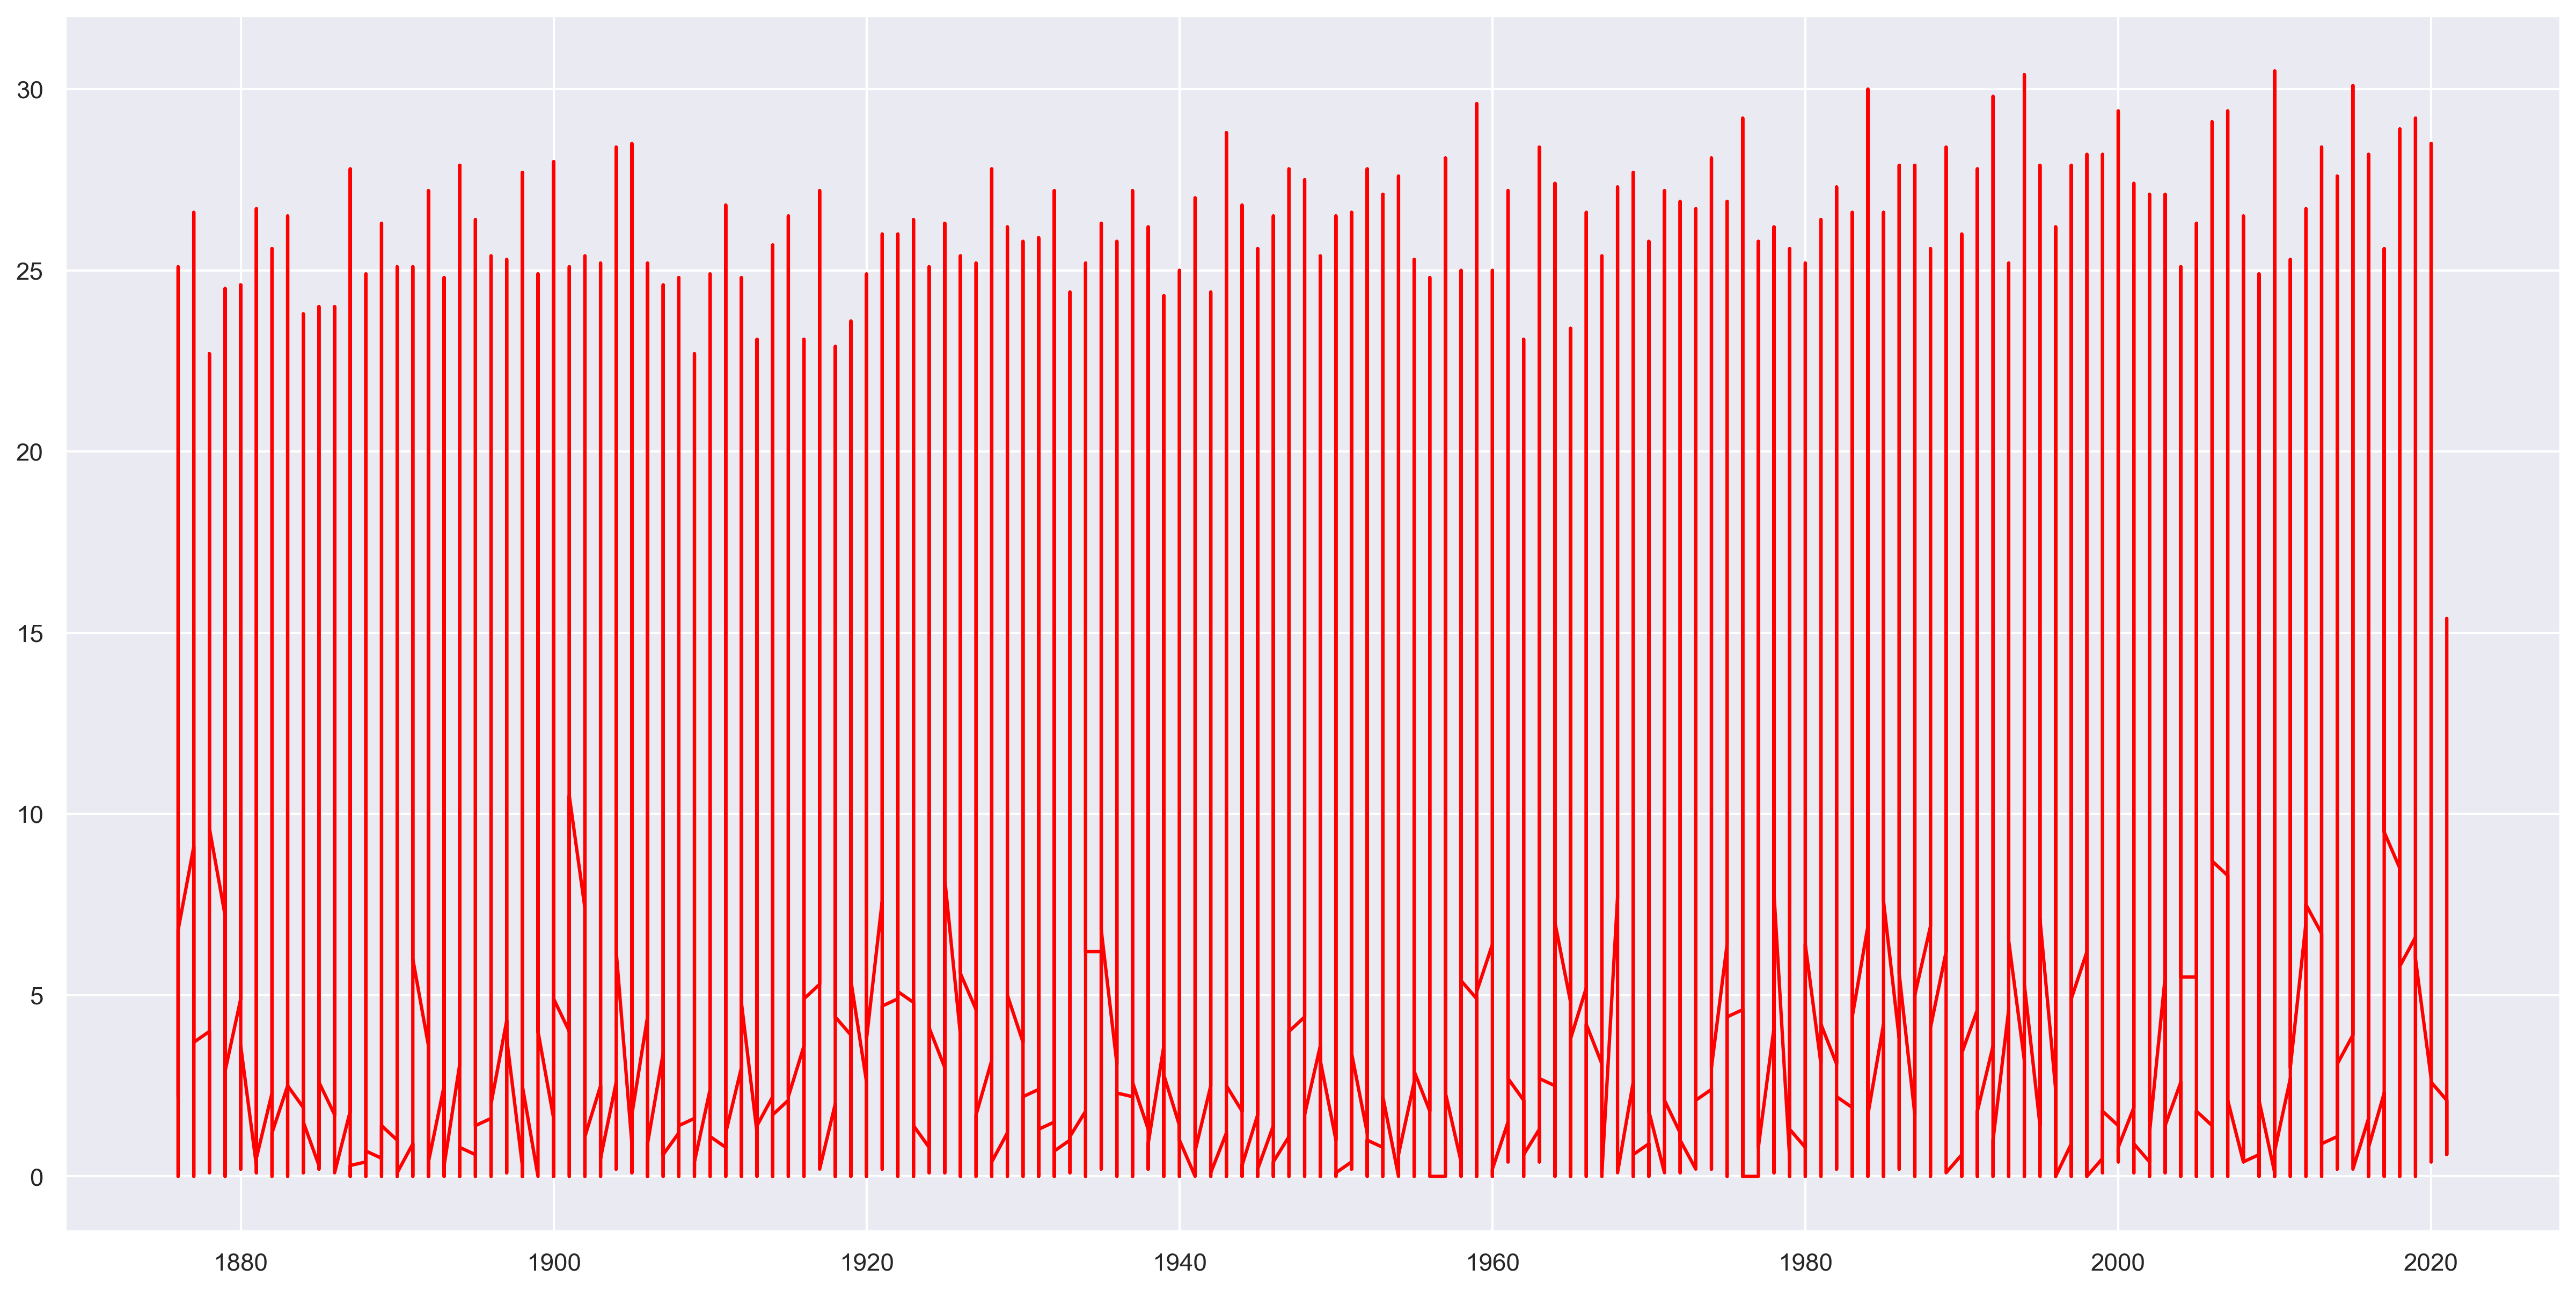

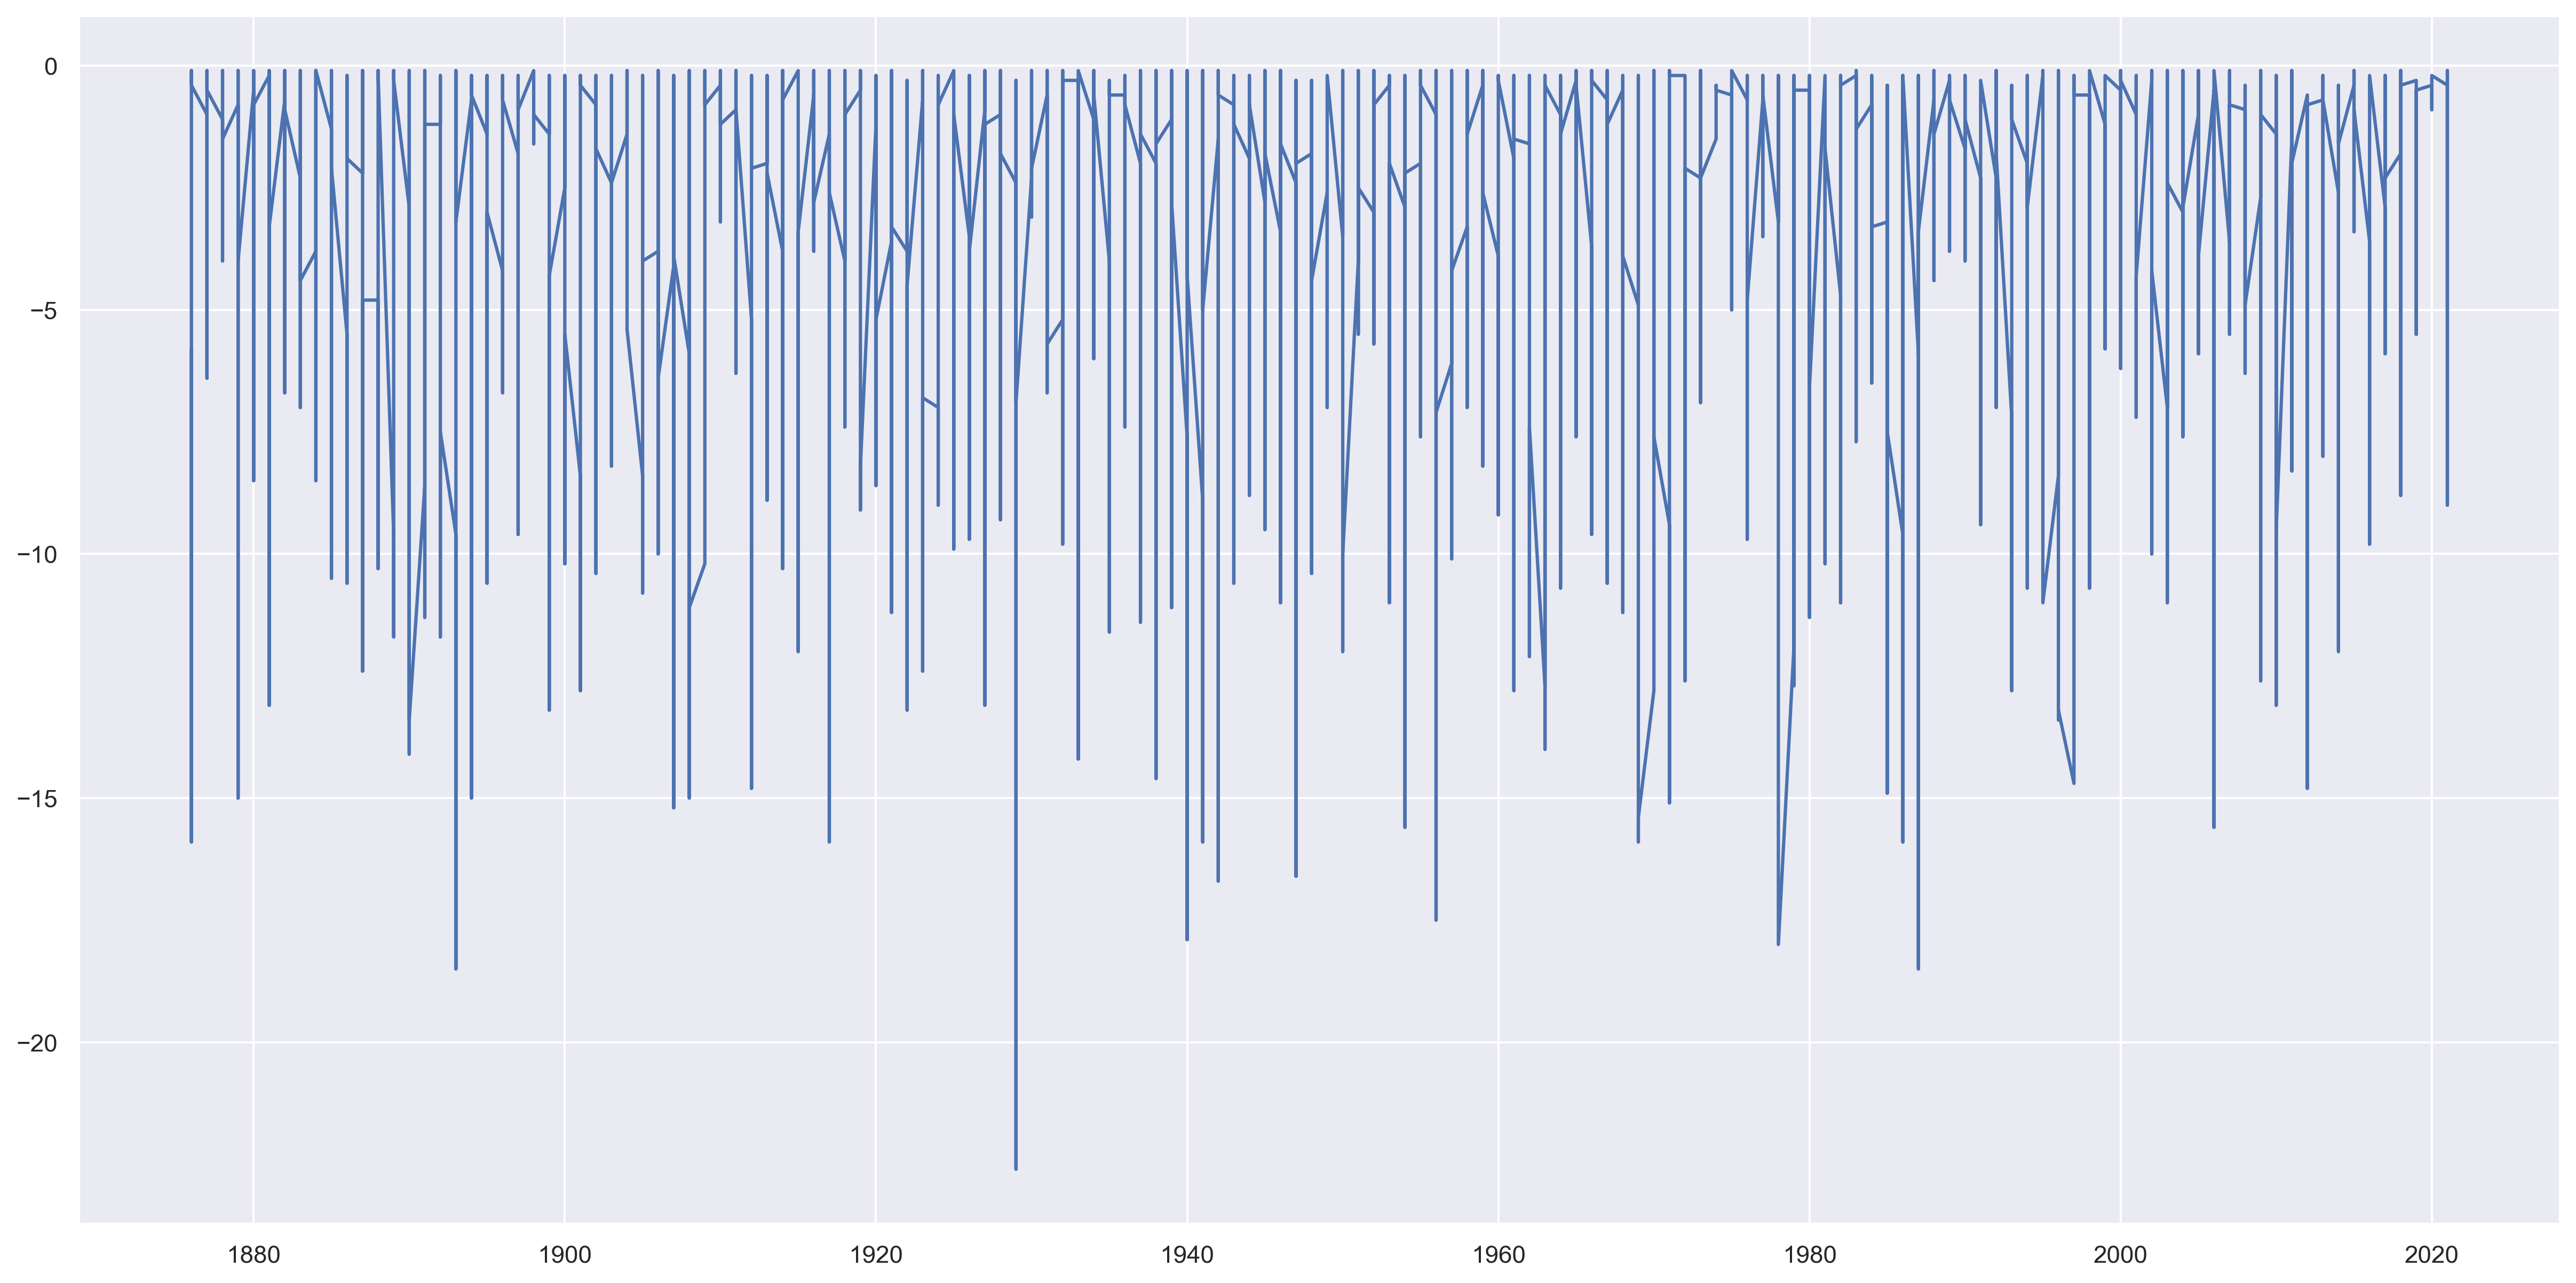

In [83]:
#Examining trends separately for + and - temperatures
mask_plus = df['tg']>=0
df_plus = df.loc[mask_plus]
plt.figure(figsize =(20, 10), dpi = 300)
plt.plot(df_plus.index.year, df_plus['tg'], color = 'red');

mask_minus = df['tg']<0
df_minus = df.loc[mask_minus]
plt.figure(figsize =(20, 10), dpi = 300)
plt.plot(df_minus.index.year, df_minus['tg']);

#The plots suggest that both summer and winter mean daily temperatures are increasing.

## Modeling the trend

In [84]:
m = LinearRegression()

In [85]:
df['timestep'] = range(len(df))

In [86]:
X = df[['timestep']] #matrix (or DataFrame)
y = df['tg']

In [87]:
X

,timestep
date,
1876-01-01,0
1876-01-02,1
1876-01-03,2
1876-01-04,3
1876-01-05,4
...,...
2021-03-27,53046
2021-03-28,53047
2021-03-29,53048


In [88]:
y

date
1876-01-01     2.2
1876-01-02     2.5
1876-01-03     0.3
1876-01-04    -5.8
1876-01-05    -9.8
              ... 
2021-03-27     6.9
2021-03-28     7.7
2021-03-29    14.4
2021-03-30    14.9
2021-03-31    15.4
Name: tg, Length: 53051, dtype: float64

In [89]:
m.fit(X,y)

LinearRegression()

In [90]:
m.coef_

array([3.19303575e-05])

In [91]:
df['trend'] = m.predict(X)

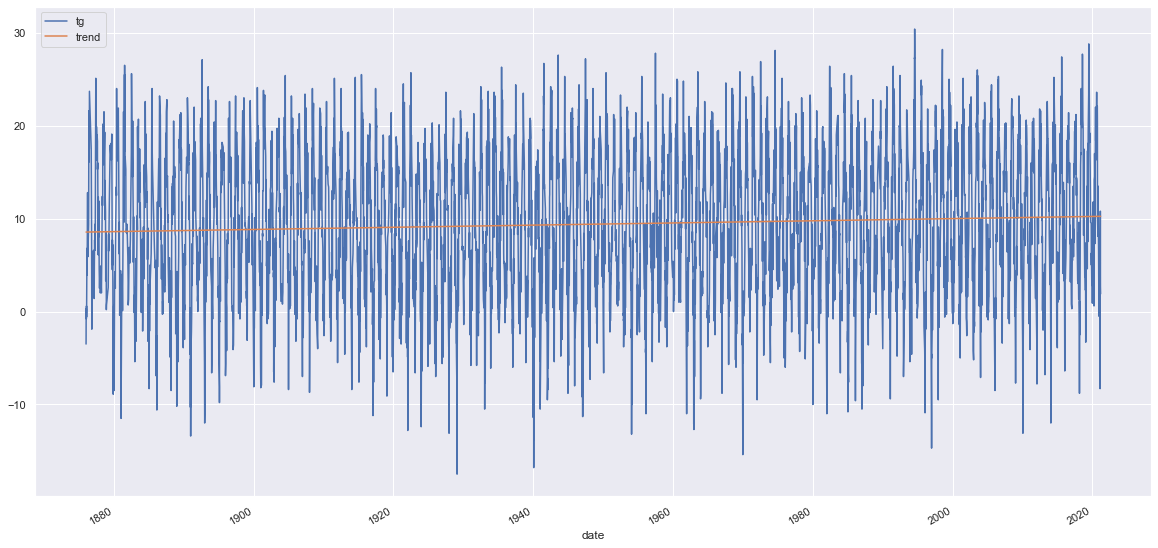

In [92]:
#To improve visualization, I plot only a 5000 data points random sample
df[['tg', 'trend']].sample(n = 5000).plot(figsize=(20,10));

## Modeling the seasonality

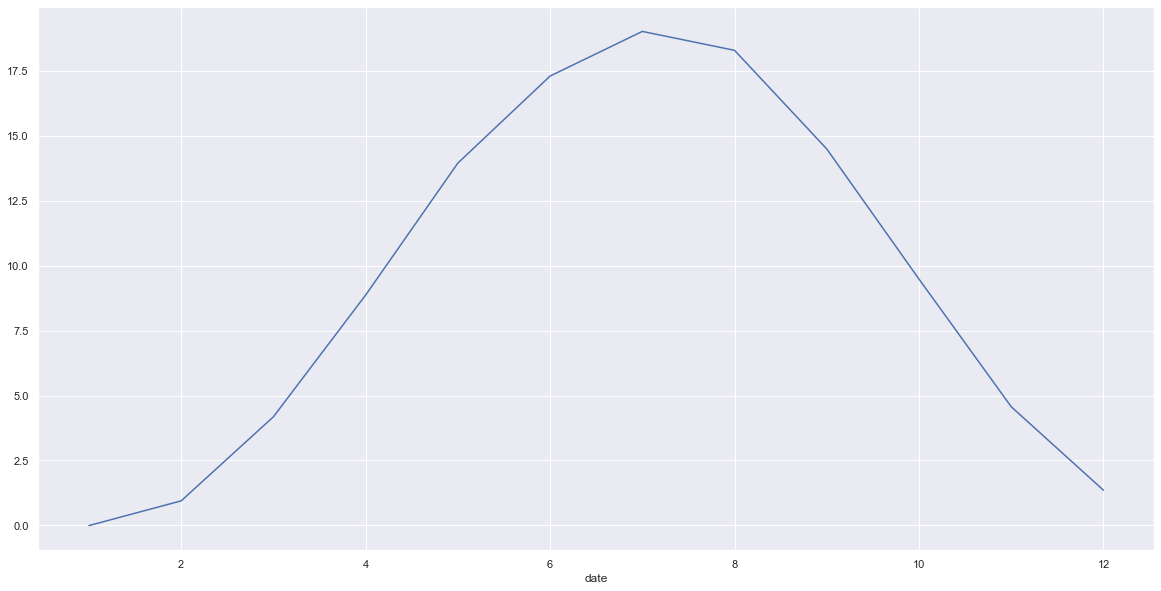

In [93]:
df.groupby(df.index.month)['tg'].mean().plot();

In [94]:
df['month'] = df.index.month

In [95]:
seasonal_dummies = pd.get_dummies(df['month'], prefix='month_')

In [96]:
df = df.merge(seasonal_dummies, left_index=True, right_index=True)

In [97]:
df

,souid,tg,timestep,trend,month,month__1,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
date,,,,,,,,,,,,,,,,,
1876-01-01,127488,2.2,0,8.552027,1,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,127488,2.5,1,8.552059,1,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,127488,0.3,2,8.552091,1,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,127488,-5.8,3,8.552123,1,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,127488,-9.8,4,8.552155,1,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,111448,6.9,53046,10.245805,3,0,0,1,0,0,0,0,0,0,0,0,0
2021-03-28,111448,7.7,53047,10.245837,3,0,0,1,0,0,0,0,0,0,0,0,0
2021-03-29,111448,14.4,53048,10.245869,3,0,0,1,0,0,0,0,0,0,0,0,0


In [98]:
X = df.drop(['souid','tg', 'trend', 'month'], axis=1)

In [99]:
y = df['tg']

In [100]:
m.fit(X, y)

LinearRegression()

In [101]:
months = df.index.month.unique()

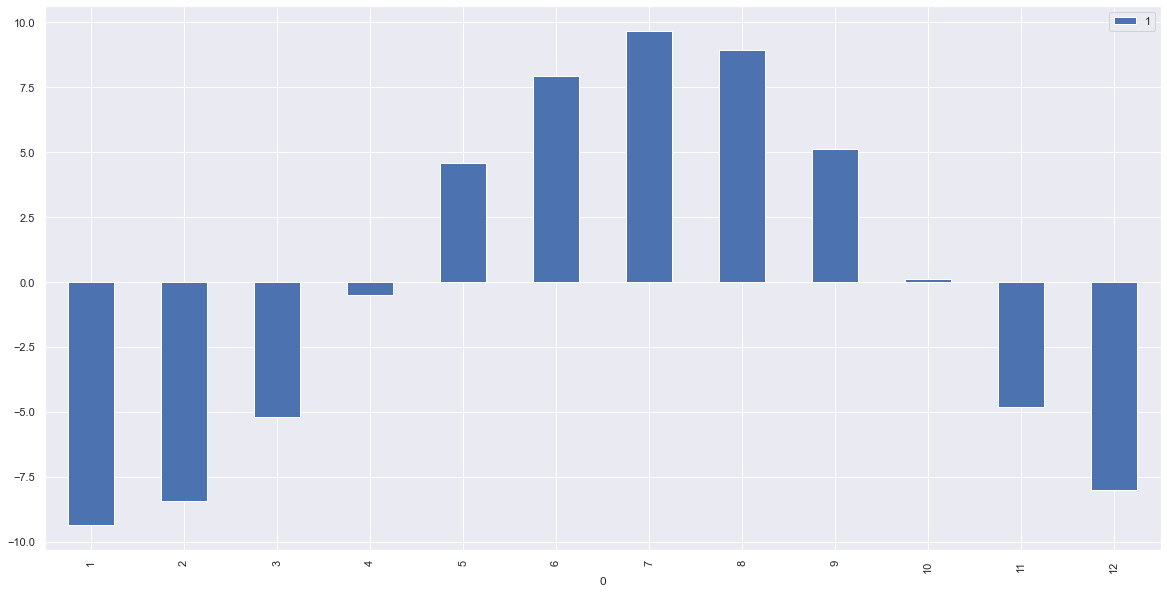

In [102]:
pd.DataFrame(zip(months, m.coef_[1:])).set_index(0).plot.bar();

In [103]:
df['trend_AND_seasonality'] = m.predict(X)

In [104]:
df['trend_AND_seasonality']

date
1876-01-01   -0.873854
1876-01-02   -0.873821
1876-01-03   -0.873788
1876-01-04   -0.873755
1876-01-05   -0.873723
                ...   
2021-03-27    5.048924
2021-03-28    5.048957
2021-03-29    5.048989
2021-03-30    5.049022
2021-03-31    5.049055
Name: trend_AND_seasonality, Length: 53051, dtype: float64

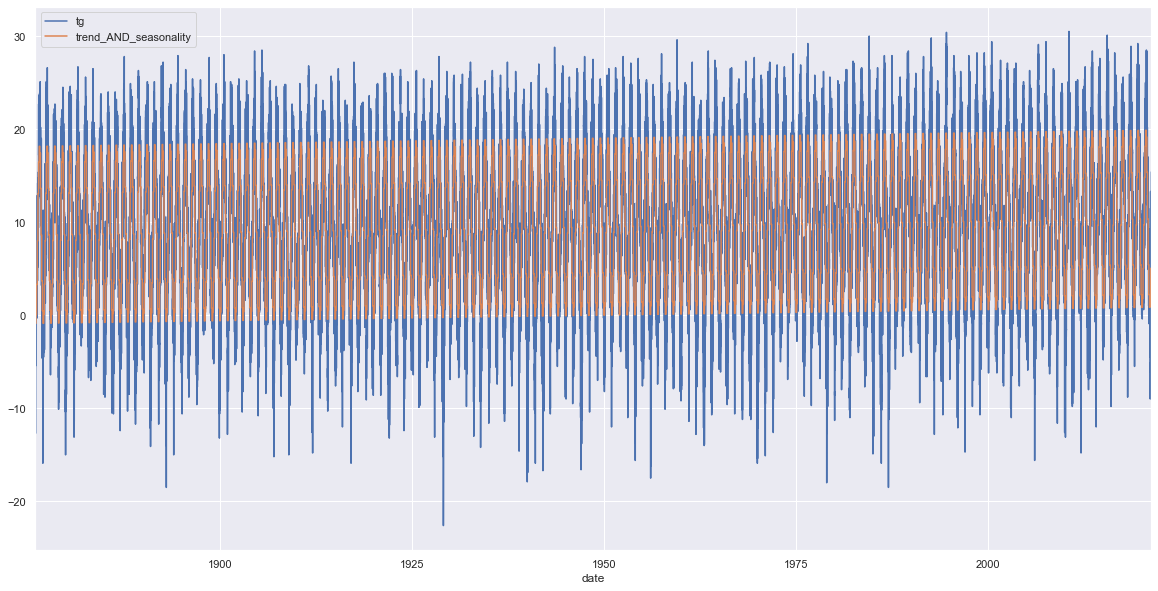

In [105]:
df[['tg', 'trend_AND_seasonality']].plot(figsize=(20,10));

In [106]:
df['remainder'] = df['tg'] - df['trend_AND_seasonality']

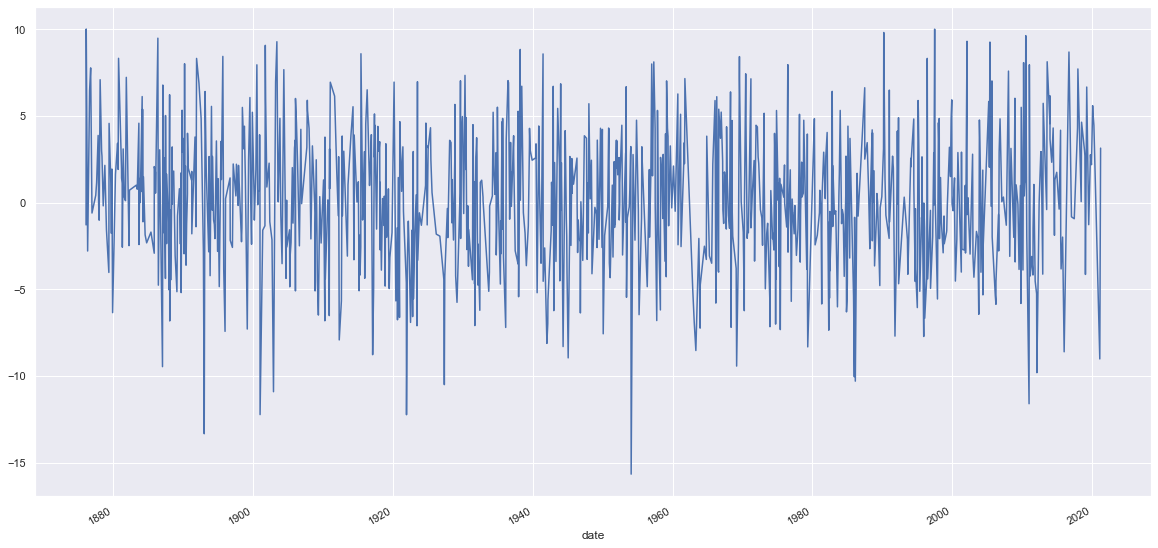

In [107]:
df['remainder'].sample(n =1000).plot(figsize=(20,10)); #I sample to improve the visualisation

In [108]:
df['remainder'].to_csv('temperatures_remainder.csv')

In [117]:
sd = seasonal_decompose(df['tg'], period = 365)

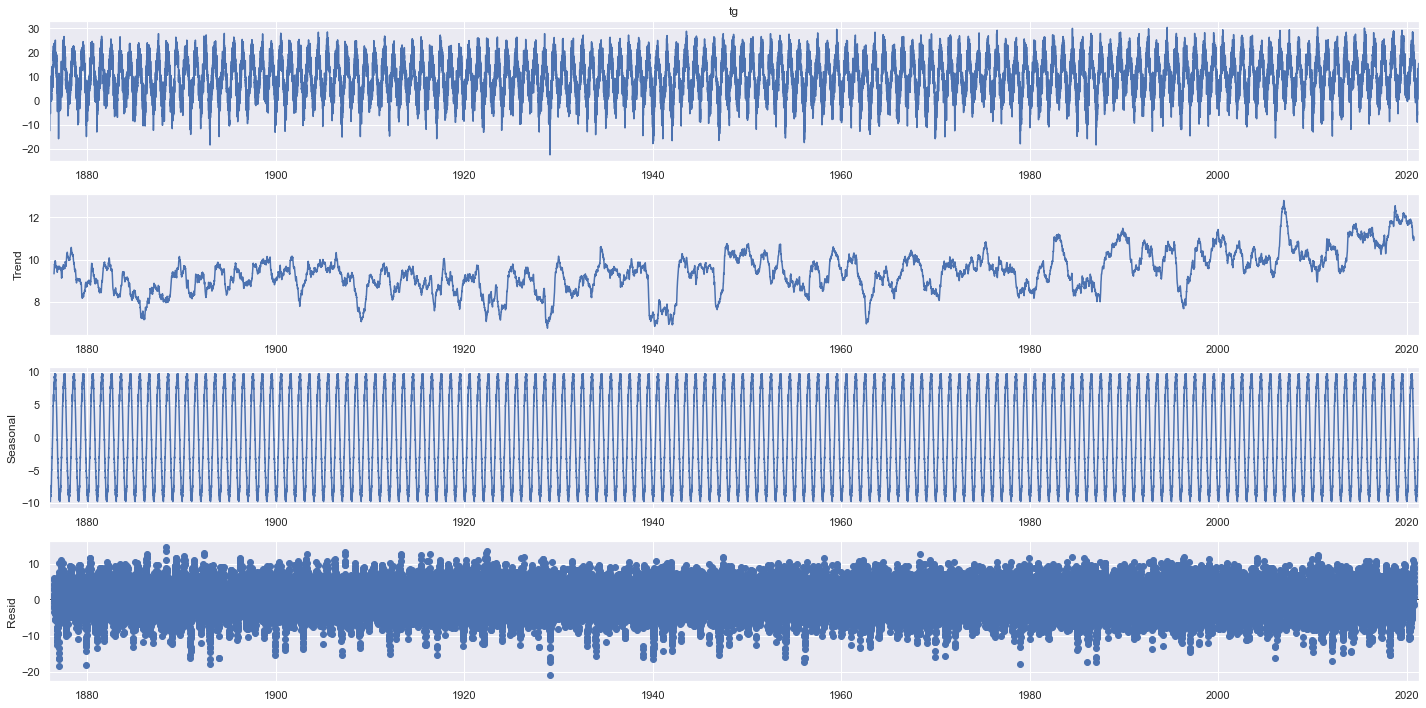

In [116]:
sd.plot()
None

## Analysing remainders

In [121]:
df = pd.read_csv('temperatures_remainder.csv', index_col=0, parse_dates=True)
df.head()

,remainder
date,
1876-01-01,3.073854
1876-01-02,3.373821
1876-01-03,1.173788
1876-01-04,-4.926245
1876-01-05,-8.926277


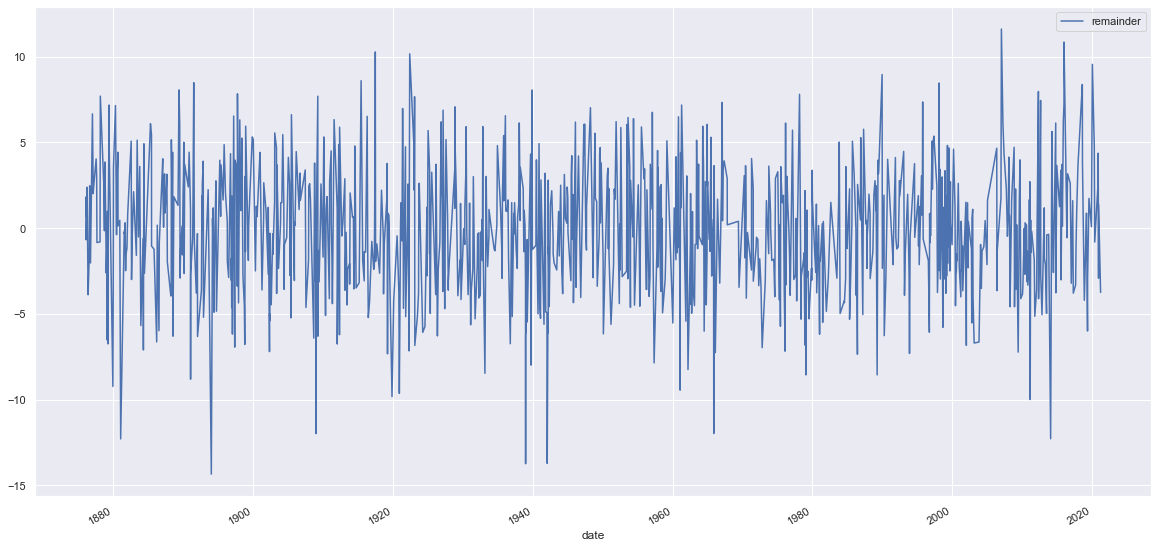

In [127]:
df.sample(n=1000).plot();

### Time lag feature

In [128]:
df['lag1'] = df['remainder'].shift(1)

In [129]:
df.head()

,remainder,lag1
date,,
1876-01-01,3.073854,NaN
1876-01-02,3.373821,3.073854
1876-01-03,1.173788,3.373821
1876-01-04,-4.926245,1.173788
1876-01-05,-8.926277,-4.926245


In [130]:
df[['remainder']].corrwith(df['lag1'])

remainder    0.803936
dtype: float64

In [131]:
correlation = round(df.corr(), 2)

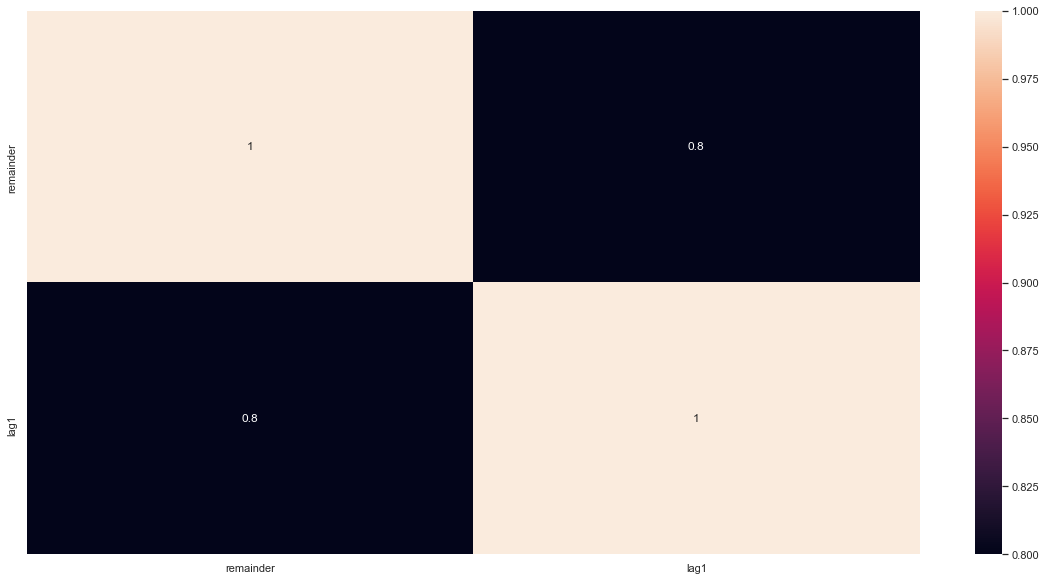

In [132]:
sns.heatmap(correlation, annot=True);

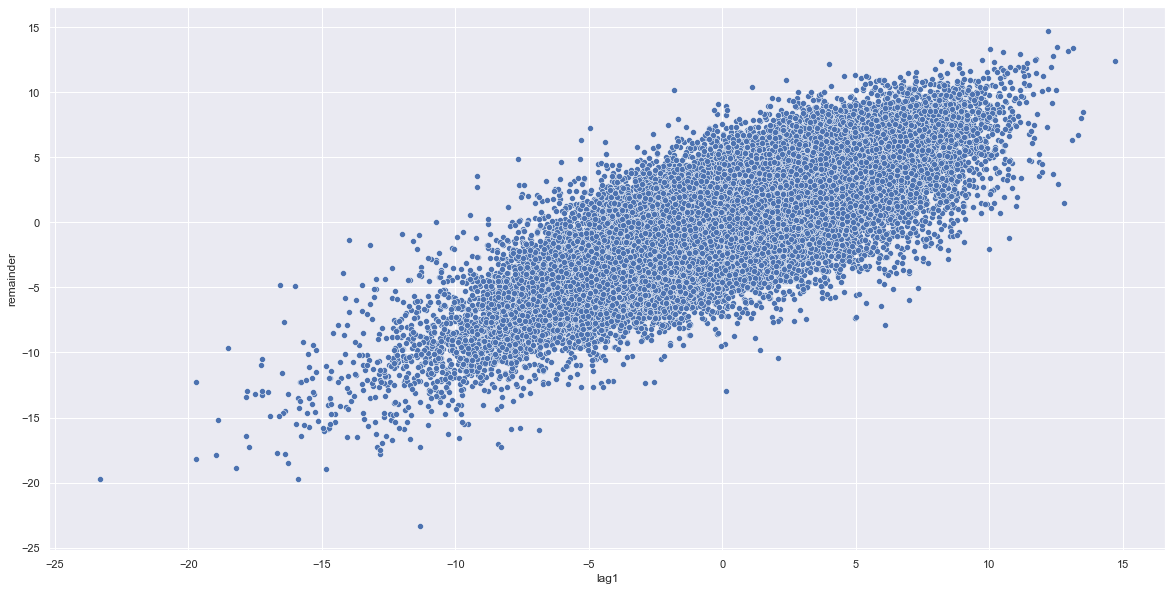

In [134]:
# Create a scatterplot
sns.scatterplot(x='lag1', y='remainder', data=df);

### Autoregressive model

In [136]:
df.dropna(inplace=True)
df

,remainder,lag1
date,,
1876-01-02,3.373821,3.073854
1876-01-03,1.173788,3.373821
1876-01-04,-4.926245,1.173788
1876-01-05,-8.926277,-4.926245
1876-01-06,-6.826310,-8.926277
...,...,...
2021-03-27,1.851076,5.751109
2021-03-28,2.651043,1.851076
2021-03-29,9.351011,2.651043


In [137]:
X = df[['lag1']]
y = df['remainder']

In [138]:
# Create and fit the model
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [139]:
# Create predictions
df['predictions_ar1'] = m.predict(X)
df.head()

,remainder,lag1,predictions_ar1
date,,,
1876-01-02,3.373821,3.073854,2.471427
1876-01-03,1.173788,3.373821,2.712595
1876-01-04,-4.926245,1.173788,0.943805
1876-01-05,-8.926277,-4.926245,-3.960521
1876-01-06,-6.826310,-8.926277,-7.176481


In [140]:
df.shape

(53050, 3)

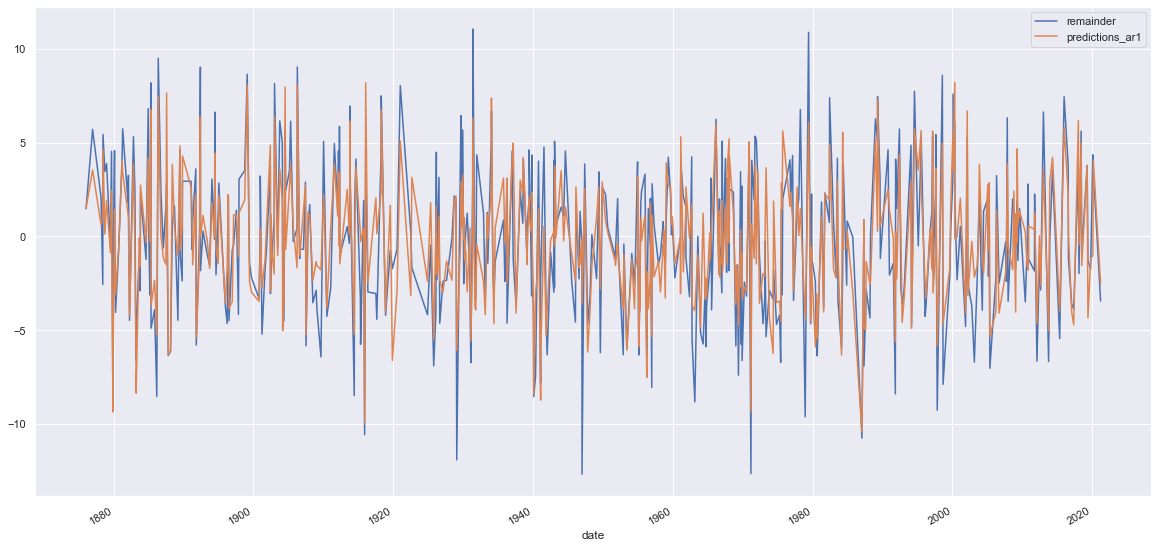

In [144]:
# Plot the original remainder and the predictions
df[['remainder', 'predictions_ar1']].sample(n = 500).plot();

### Residuals

In [145]:
# What is the residual compared to the remainder?
df['residual'] = df['remainder'] - df['predictions_ar1']
df.head()

,remainder,lag1,predictions_ar1,residual
date,,,,
1876-01-02,3.373821,3.073854,2.471427,0.902394
1876-01-03,1.173788,3.373821,2.712595,-1.538807
1876-01-04,-4.926245,1.173788,0.943805,-5.870050
1876-01-05,-8.926277,-4.926245,-3.960521,-4.965757
1876-01-06,-6.826310,-8.926277,-7.176481,0.350171


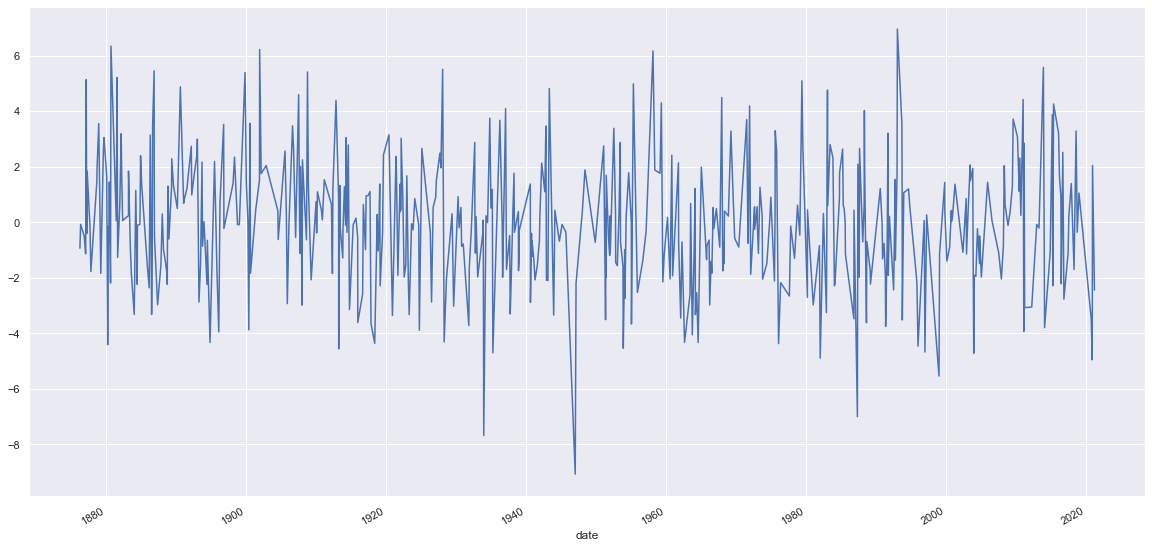

In [148]:
df['residual'].sample (n=500).plot();

In [149]:
df['lag2'] = df.remainder.shift(2)
df.head()

,remainder,lag1,predictions_ar1,residual,lag2
date,,,,,
1876-01-02,3.373821,3.073854,2.471427,0.902394,NaN
1876-01-03,1.173788,3.373821,2.712595,-1.538807,NaN
1876-01-04,-4.926245,1.173788,0.943805,-5.870050,3.373821
1876-01-05,-8.926277,-4.926245,-3.960521,-4.965757,1.173788
1876-01-06,-6.826310,-8.926277,-7.176481,0.350171,-4.926245


In [150]:
df.dropna()

,remainder,lag1,predictions_ar1,residual,lag2
date,,,,,
1876-01-04,-4.926245,1.173788,0.943805,-5.870050,3.373821
1876-01-05,-8.926277,-4.926245,-3.960521,-4.965757,1.173788
1876-01-06,-6.826310,-8.926277,-7.176481,0.350171,-4.926245
1876-01-07,-5.726343,-6.826310,-5.488142,-0.238201,-8.926277
1876-01-08,-8.026376,-5.726343,-4.603787,-3.422589,-6.826310
...,...,...,...,...,...
2021-03-27,1.851076,5.751109,4.623896,-2.772820,4.251142
2021-03-28,2.651043,1.851076,1.488334,1.162710,5.751109
2021-03-29,9.351011,2.651043,2.131494,7.219516,1.851076


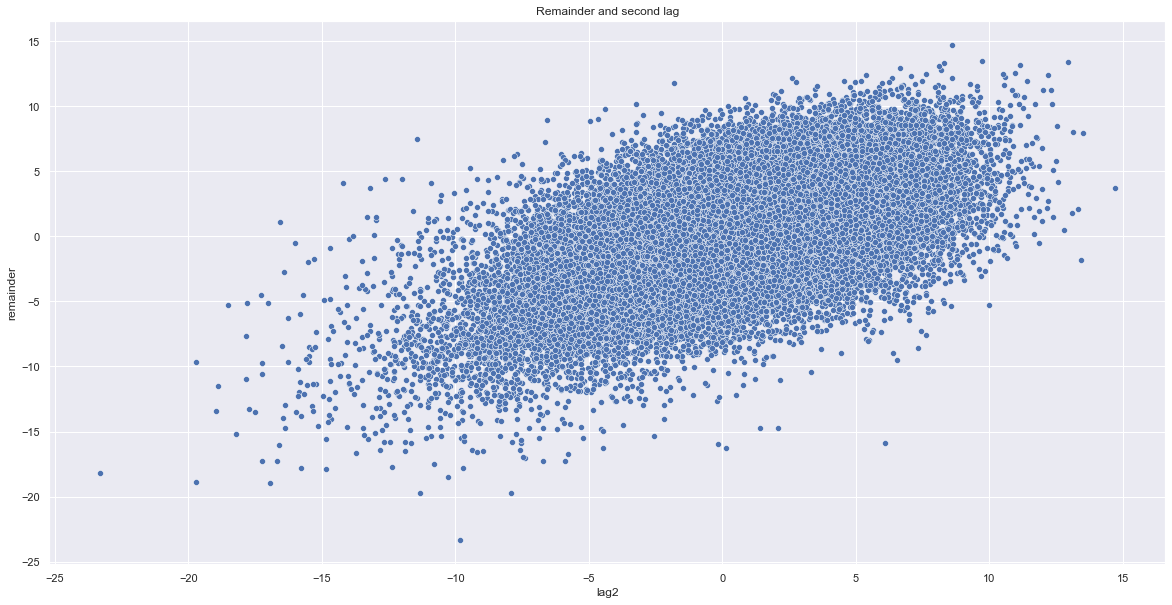

In [151]:
# Plot the second lag against the remainder
sns.scatterplot(x='lag2', y='remainder', data=df)
plt.title('Remainder and second lag')
plt.show()

<AxesSubplot:>

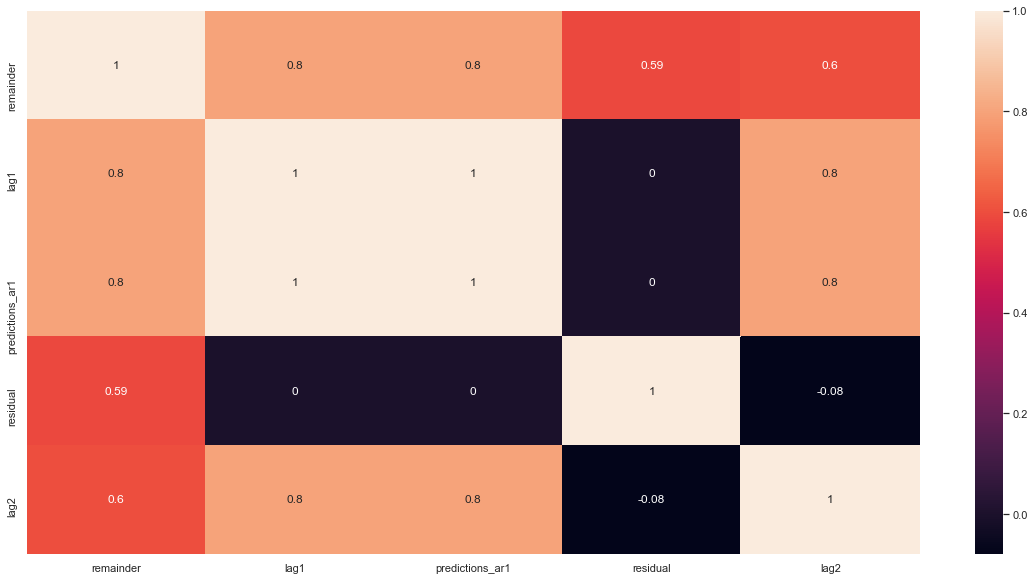

In [152]:
# Inspect correlations
correlations = round(df.corr(), 2)
sns.heatmap(correlations, annot=True)

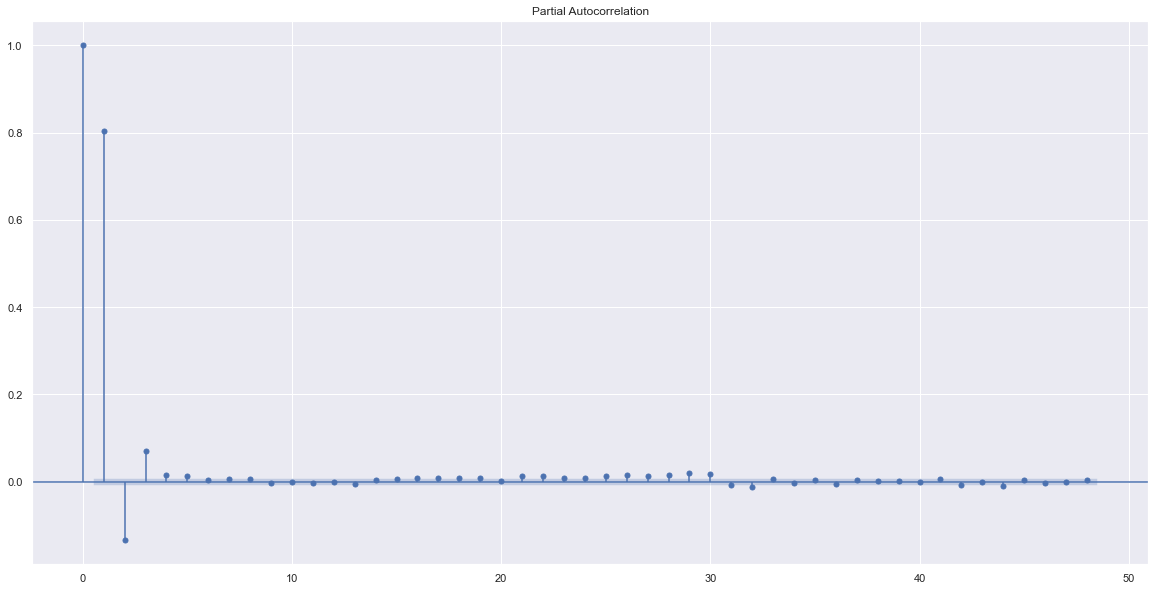

In [153]:
# Statsmodels provides a function called plot_pacf
# plot partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['remainder']);

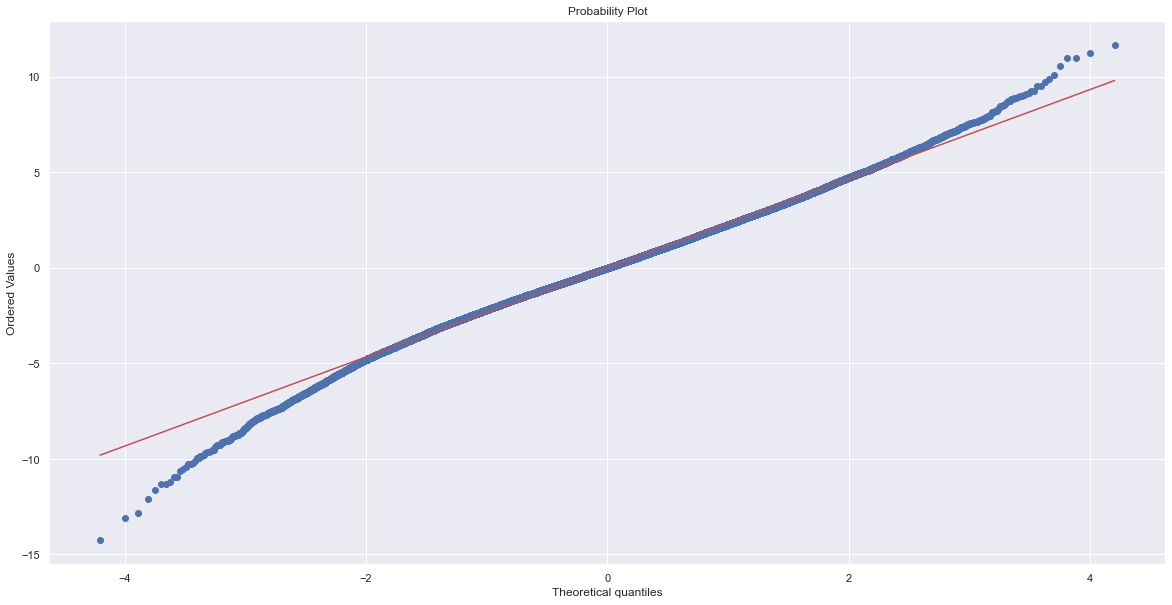

In [154]:
import numpy as np
stats.probplot(df['residual'], dist="norm", plot=py)
py.show()

In [155]:
from scipy.stats import jarque_bera
test = df['residual'].to_numpy()

jarque_bera(test)

Jarque_beraResult(statistic=1141.425723672589, pvalue=0.0)

In [163]:
selected_order = ar_select_order(endog=df['remainder'], maxlag=12, old_names=False)

/Users/giudittaparolini/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/giudittaparolini/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [164]:
selected_order.ar_lags

array([1, 2, 3, 4])

In [165]:
ar_model = AutoReg(endog=df['remainder'], lags=4).fit()

/Users/giudittaparolini/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/giudittaparolini/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [166]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                53050
Model:                     AutoReg(4)   Log Likelihood             -119654.163
Method:               Conditional MLE   S.D. of innovations              2.309
Date:                Wed, 28 Apr 2021   AIC                              1.674
Time:                        00:02:46   BIC                              1.675
Sample:                    01-06-1876   HQIC                             1.674
                         - 03-31-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0003      0.010      0.029      0.977      -0.019       0.020
remainder.L1     0.9187      0.004    211.617      0.000       0.910       0.927
remainder.L2    -0.1931      0.006    -32.784      0.000      -0.205      -0.182
remainder.L3     0.0550      0.006      9.345      0.000       0.044       0.067
remainder.L4     0.0163      0.004      3.753      0.000       0.008       0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2574           -0.0000j            1.2574           -0.0000
AR.2            1.0055           -2.5165j            2.7099           -0.1895
AR.3            1.0055           +2.5165j            2.7099            0.1895
AR.4           -6.6472           -0.0000j            6.6472           -0.5000
-----------------------------------------------------------------------------
"""